In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from templates import *

In [25]:
conf.fp16

True

In [72]:
device = 'cuda'
conf = ffhq256_autoenc()
conf.fp16 = False
# print(conf.name)
model = LitModel(conf)
state = torch.load(f'last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

Global seed set to 0


Model params: 160.69 M


In [122]:
xT.std()

tensor(1.0067, device='cuda:0')

In [73]:
data = ImageDataset('imgs_align', image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
batch = data[0]['img'][None]

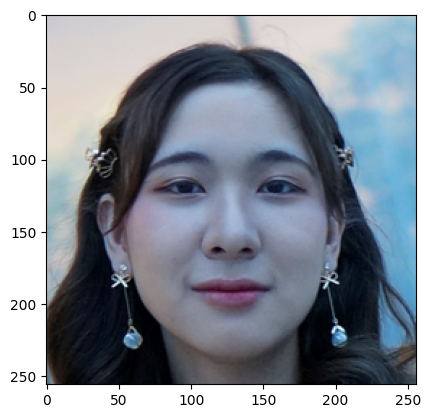

In [74]:
import matplotlib.pyplot as plt
plt.imshow(batch[0].permute([1, 2, 0]) / 2 + 0.5)

# Encode

In [75]:
cond = model.encode(batch.to(device))
x = batch.to(device)
xT = model.encode_stochastic(x, cond, T=250)

In [76]:
model.cuda()

LitModel(
  (model): BeatGANsAutoencModel(
    (time_embed): TimeStyleSeperateEmbed(
      (time_embed): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): SiLU()
        (2): Linear(in_features=512, out_features=512, bias=True)
      )
      (style): Identity()
    )
    (input_blocks): ModuleList(
      (0): TimestepEmbedSequential(
        (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): TimestepEmbedSequential(
        (0): ResBlock(
          (in_layers): Sequential(
            (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
            (1): SiLU()
            (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (h_upd): Identity()
          (x_upd): Identity()
          (emb_layers): Sequential(
            (0): SiLU()
            (1): Linear(in_features=512, out_features=256, bias=True)
          )
          (cond_emb_layers): Sequential(
            (0):

In [77]:
t, weight = model.T_sampler.sample(len(x), x.device)

In [78]:
cond.shape

torch.Size([1, 512])

In [79]:
losses = model.sampler.training_losses(model=model.model,x_start=x,t=t,model_kwargs=dict(cond=cond))

In [100]:
model.model

BeatGANsAutoencModel(
  (time_embed): TimeStyleSeperateEmbed(
    (time_embed): Sequential(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): SiLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
    (style): Identity()
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=512, out_features=256, bias=True)
        )
        (cond_emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=512, out_features=128, bias=True)

In [114]:
cond.requires_grad=True
r = model.model.forward(x=xT.detach(),
                      t=model.sampler._scale_timesteps(t),
                      cond=cond)

In [119]:
t

tensor([548], device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


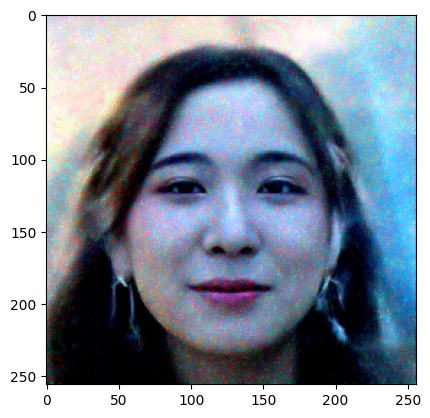

In [115]:

plt.imshow(rr['pred_xstart'][0].permute(1, 2, 0).detach().cpu()+0.5)

In [113]:
cond.requires_grad

False

In [118]:
torch.autograd.grad(rr['pred_xstart'].sum(),[cond,])

(tensor([[-5.2278e+02,  2.0758e+02, -1.6566e+03, -2.4492e+03, -1.2830e+02,
          -5.6230e+02, -4.4663e+02, -2.8546e+03,  1.7377e+03,  8.1241e+02,
           5.9011e+03, -1.4525e+01,  1.7032e+03, -9.2252e+02, -3.7565e+03,
          -4.9215e+03,  1.5913e+03, -1.8734e+03,  3.8449e+02,  1.0879e+03,
          -8.3862e+02, -9.2330e+01,  1.5629e+03,  1.0741e+03,  1.7821e+03,
          -6.2378e+03, -2.8031e+03,  4.4184e+01, -4.8062e+02,  2.6639e+03,
          -1.8104e+03, -4.5452e+02,  1.2265e+03,  1.8456e+03, -1.0716e+02,
           7.8227e+01, -3.5158e+03,  4.2711e+03,  7.7618e+03,  8.3251e+02,
           6.6350e+03, -2.9147e+03,  2.5649e+03, -2.2772e+03,  4.6774e+02,
           2.5891e+03, -2.0018e+03, -1.2126e+02,  1.8284e+02,  1.2108e+03,
           2.8750e+03,  2.0083e+03,  4.5367e+03,  1.7163e+03, -7.8345e+02,
           3.9677e+03,  2.7038e+03,  3.4555e+01,  2.1519e+03, -3.0120e+03,
          -4.7214e+03, -7.9124e+02, -1.4816e+03,  2.7954e+03,  2.6216e+03,
          -7.9672e+02, -3

In [116]:
from diffusion.base import DummyModel
rr = model.sampler.p_mean_variance(
                model=DummyModel(pred=r.pred),
                # gradient goes through x_t
                x=xT,
                t=t,
                clip_denoised=False)

In [117]:
rr['pred_xstart']

tensor([[[[ 0.2539,  0.3123,  0.2798,  ...,  0.2480,  0.2339,  0.1584],
          [ 0.2755,  0.3480,  0.2971,  ...,  0.1800,  0.2741,  0.2109],
          [ 0.2280,  0.3377,  0.3618,  ...,  0.1311,  0.1753,  0.1976],
          ...,
          [-0.5818, -0.4200, -0.3571,  ..., -0.3529, -0.3471, -0.2689],
          [-0.6674, -0.5249, -0.5413,  ..., -0.2534, -0.2391, -0.2115],
          [-0.8124, -0.7009, -0.7056,  ..., -0.3054, -0.3202, -0.1961]],

         [[ 0.4615,  0.4439,  0.3950,  ...,  0.3453,  0.3865,  0.3495],
          [ 0.4838,  0.3582,  0.3138,  ...,  0.3527,  0.3975,  0.2763],
          [ 0.4044,  0.3710,  0.4014,  ...,  0.3593,  0.2929,  0.1751],
          ...,
          [-0.2862, -0.2129, -0.3444,  ..., -0.1598, -0.1719, -0.2480],
          [-0.2953, -0.3486, -0.3161,  ..., -0.1008, -0.1441, -0.1218],
          [-0.2415, -0.3776, -0.3110,  ..., -0.1944, -0.2145, -0.0534]],

         [[ 0.3164,  0.3251,  0.2805,  ...,  0.2967,  0.3011,  0.3034],
          [ 0.4046,  0.4481,  

In [80]:
losses.keys()

dict_keys(['x_t', 'pred_xstart', 'mse', 'loss'])

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

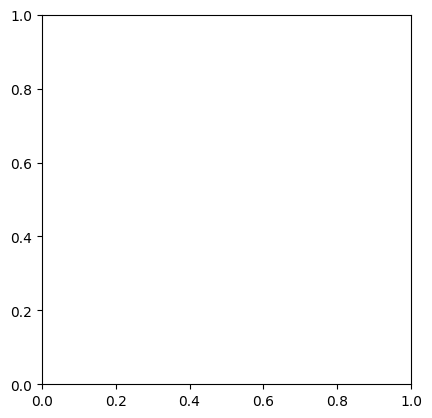

In [109]:
plt.imshow(losses['pred_xstart'][0].permute(1, 2, 0).cpu()+0.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


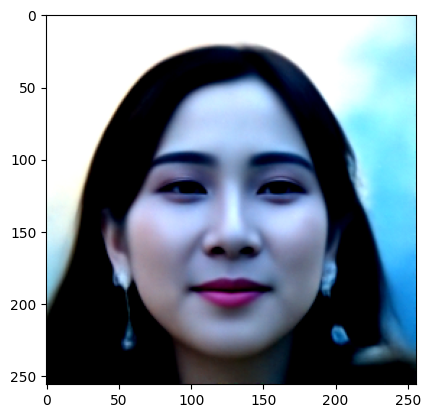

In [86]:
plt.imshow(losses['pred_xstart'][0].permute(1, 2, 0).cpu()+0.5)

In [52]:
cond.requires_grad = True

In [69]:
model.sampler.sample(model=model.model,noise=x,model_kwargs=dict(cond=cond))

tensor([[[[ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          ...,
          [ 1.,  1.,  1.,  ..., -1., -1., -1.],
          [ 1.,  1.,  1.,  ..., -1., -1., -1.],
          [ 1.,  1.,  1.,  ..., -1., -1., -1.]]]], device='cuda:0')

In [59]:
cond.requires_grad

True

In [60]:
pred.requires_grad

False

In [57]:
torch.autograd.grad(pred.sum(),[cond])

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [48]:
losses

{'x_t': tensor([[[[ 1.1047, -0.1624, -1.0569,  ..., -0.5221, -0.3589,  0.4140],
           [-0.3103, -0.7032,  0.3143,  ..., -0.6289,  0.0075,  0.7033],
           [-1.8233,  0.1230,  1.1865,  ..., -0.4648, -0.9774, -0.0083],
           ...,
           [-1.3402, -0.7306, -1.3160,  ..., -1.2329, -1.7640, -0.8047],
           [-1.2701, -0.7778, -0.3844,  ..., -0.1168, -0.2486, -0.4241],
           [ 1.0133, -0.4937,  0.8528,  ...,  0.0660, -1.4844, -1.0848]],
 
          [[ 0.5825, -0.7814, -0.4521,  ...,  1.2811,  0.1787, -1.1359],
           [-0.0109,  0.2586,  0.4373,  ...,  1.8979,  0.4883, -0.0814],
           [-0.1046,  1.6054,  1.4440,  ..., -1.1123,  0.5411,  1.1177],
           ...,
           [-0.9358,  0.7272,  1.0076,  ..., -0.2070, -1.2208, -0.0710],
           [ 0.0859, -0.6619, -3.0431,  ...,  0.8301,  1.0685, -0.0614],
           [ 0.0613, -1.5625,  0.3781,  ...,  0.3443,  0.6470, -0.9284]],
 
          [[ 0.9524,  1.0637, -0.0295,  ..., -0.5582,  0.2212, -0.1950],
      

In [13]:
torch.autograd.grad(xT,)

torch.Size([1, 3, 256, 256])

In [9]:
import torch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


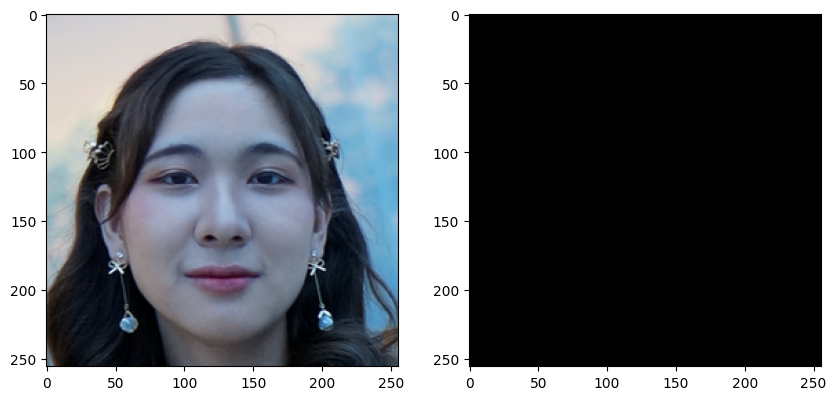

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(xT[0].permute(1, 2, 0).cpu())

# Decode

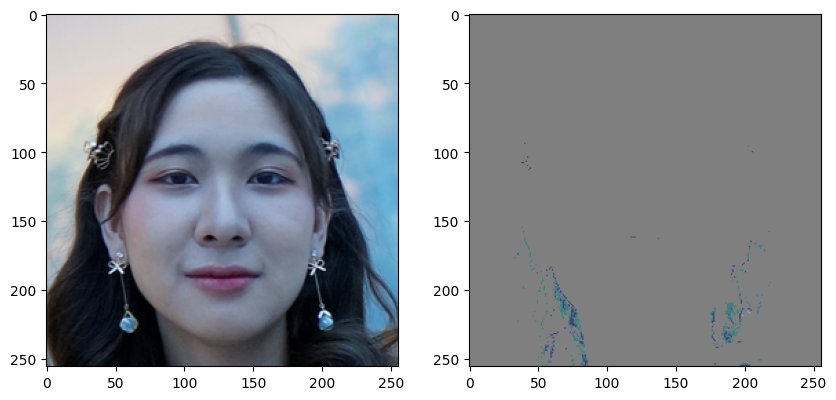

In [14]:
pred = model.render(xT, cond, T=20)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(pred[0].permute(1, 2, 0).cpu())

In [16]:
torch.autograd.grad(pred,[cond])

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn